In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import segyio

In [31]:
def obj_to_pixel_df(obj, width, height, index_label, derivative='default'):

    dataset = pd.DataFrame()

    if width % 2 > 0:
        width_coef = 1
    else:
        width_coef = 0
    
    if height % 2 > 0:
        height_coef = 1
    else:
        height_coef = 0

    half_width = int(round(width / 2 - 0.5, 0))
    half_height = int(round(height / 2 - 0.5, 0))
    
    count = 0
    for click in obj:
        iline_number = click['inline']
        xline_number = click['crossline']

        x = click['x']
        y = click['y']

        if iline_number != None:
            img = f3_seismic.iline[iline_number][x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]
        else:
            img = f3_seismic.xline[xline_number][x - half_width : x + half_width + width_coef, y - half_height : y + half_height + height_coef]

        img = img.T

        if derivative == 'horizontal':
            img = np.diff(img) / 25
        elif derivative == 'vertical':
            img = np.diff(img.T).T / 0.004

        pixels = img.reshape(-1,1)

        if derivative == 'default':
            if len(pixels) == int(width * height):
                dataset[count] = [pixel[0] for pixel in pixels.tolist()]
        else:
            if len(pixels) == int(width * height - width):
                dataset[count] = [pixel[0] for pixel in pixels.tolist()]

        count += 1

    dataset = dataset.T
    dataset.index = [f'{index_label}{i}' for i in range(len(dataset))]

    if index_label == 'Fault':
        dataset['y'] = [1 for i in range(len(dataset))]

    elif index_label == 'Non_Fault':
        dataset['y'] = [0 for i in range(len(dataset))]

    return dataset

In [4]:
path = r'/home/gaia/jpedro/Seismic_data_w_null.sgy'
f3_seismic = segyio.open(path)

In [5]:
file = open('Fault.obj', 'rb')
fault_obj = pickle.load(file)
file.close()

file = open('Non_Fault.obj', 'rb')
non_fault_obj = pickle.load(file)
file.close()

In [6]:
#fault_obj

In [7]:
width = 21
height = 21

X_fault = obj_to_pixel_df(fault_obj, width, height, 'Fault')
X_non_fault = obj_to_pixel_df(non_fault_obj, width, height, 'Non_Fault')

dataset = pd.concat([X_fault, X_non_fault])

dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

dataset = dataset.sample(frac=1)

X = dataset.iloc[:,:-1]
y = dataset['y']

/tmp/ipykernel_3895/1118644595.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]


In [33]:
print(dataset)
print('-'*80)
print(X)
print('-'*80)
print(y)

                    Pixel0        Pixel1        Pixel2        Pixel3  \
Fault600      8.657499e+05  7.592499e+05 -1.862500e+05 -4.460000e+05   
Fault499      2.455000e+05  1.058500e+06  7.829999e+05  9.319999e+05   
Fault292      2.145000e+05  1.580000e+05 -5.750000e+04  2.060000e+05   
Non_Fault178 -5.800000e+05 -3.410000e+05 -1.492500e+05 -4.100000e+04   
Fault79      -1.024500e+06 -9.722499e+05 -1.475250e+06 -1.203250e+06   
...                    ...           ...           ...           ...   
Fault377     -1.240000e+05  8.749999e+04  1.617500e+05 -2.165000e+05   
Fault148     -2.697000e+06 -2.420000e+06 -2.265500e+06 -2.171250e+06   
Non_Fault367  7.784999e+05  2.465000e+05  2.620000e+05  8.814999e+05   
Non_Fault536 -2.825000e+04  6.100000e+04  1.012500e+05 -2.087500e+05   
Fault170      9.694999e+05  9.309999e+05  8.547499e+05  9.049999e+05   

                    Pixel4        Pixel5        Pixel6        Pixel7  \
Fault600     -6.767499e+05 -1.225000e+04 -5.857500e+05  2.28500

In [9]:
#vmin = -4000
#vmax = 4000

#index = 17
#img = np.array(X.iloc[index:index + 1,:]).reshape(width, height)
#plt.imshow(img, cmap='gray_r', aspect='auto', vmin=vmin, vmax=vmax, interpolation='spline36')

In [10]:
def norm_data(X,x_min,x_max):
    return (X-x_min)/(x_max-x_min)

In [11]:
#X_max, X_min = np.max(np.asarray(X)), np.min(np.asarray(X))
#X_norm = norm_data(X,X_max,X_min)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9,
                                     train_size=0.7)

In [13]:
#clf = LogisticRegression(penalty='none', 
#                         solver='saga',
#                         n_jobs=-1,
#                         multi_class='multinomial').fit(X_train, y_train)

#clf.coef_.shape

In [14]:
#y_pred = clf.predict(X_test)
#acc = accuracy_score(y_test, y_pred)

#y_pred_train = clf.predict(X_train)
#acc_train = accuracy_score(y_train, y_pred_train)

#print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc * 100, 2)}%')

In [15]:
#from sklearn.neighbors import KNeighborsClassifier

In [16]:
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train,y_train)

#y_pred = knn.predict(X_test)
#acc = accuracy_score(y_test, y_pred)

#y_pred_train = knn.predict(X_train)
#acc_train = accuracy_score(y_train, y_pred_train)

#print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc * 100, 2)}%')

In [17]:
#acc_k_train = []
#acc_k_test = []

#for k in range(3,51,2):
#    knn = KNeighborsClassifier(n_neighbors=k)
#    knn.fit(X_train,y_train)

#    y_pred = knn.predict(X_test)
#    acc = accuracy_score(y_test, y_pred)

#    y_pred_train = knn.predict(X_train)
#    acc_train = accuracy_score(y_train, y_pred_train)

#    acc_k_train += [acc_train]
#    acc_k_test += [acc]

#plt.plot(range(3,51,2), acc_k_train)
#plt.plot(range(3,51,2), acc_k_test)

In [18]:
#plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [19]:
#print(classification_report(y_test,y_pred))

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [21]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f'Model Accuracy (Train): {round(acc_train * 100, 2)}% | Model Accuracy (Test): {round(acc * 100, 2)}%')

Model Accuracy (Train): 88.03% | Model Accuracy (Test): 68.16%


/home/gaia/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


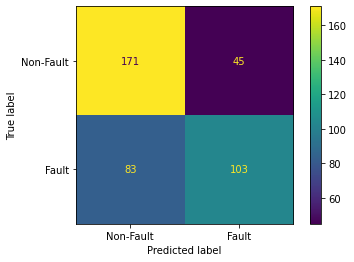

In [22]:
plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Fault', 'Fault'])

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73       216
           1       0.70      0.55      0.62       186

    accuracy                           0.68       402
   macro avg       0.68      0.67      0.67       402
weighted avg       0.68      0.68      0.68       402



In [24]:
#plt.figure(figsize=(60,60))
#plot_tree(model, filled=True, rounded=True, class_names=['Non-Fault', 'Fault'], feature_names=X_train.columns)

In [ ]:
depth_range = range(3, 31, 2)
width_range = range(11, 32, 2)

plt.figure(figsize=(15,10))

for width in width_range:
    height = width


    X_fault = obj_to_pixel_df(fault_obj, width, height, 'Fault')
    X_non_fault = obj_to_pixel_df(non_fault_obj, width, height, 'Non_Fault')

    dataset = pd.concat([X_fault, X_non_fault])

    dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

    dataset = dataset.sample(frac=1)

    X = dataset.iloc[:,:-1]
    y = dataset['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    acc_test_list = []
    acc_train_list = []

    for depth in depth_range:
        acc_test_mean_list = []
        acc_train_mean_list = []

        for i in range(5):

            model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            y_pred_train = model.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)

            acc_test_mean_list += [acc * 100]
            acc_train_mean_list += [acc_train * 100]
        
        acc_test_list += [np.mean(acc_test_mean_list)]
        acc_train_list += [np.mean(acc_train_mean_list)]

    plt.plot(depth_range, acc_test_list, label=f'Teste | w_h: {width} x {height}')
    #plt.plot(depth_range, acc_train_list, label=f'Treino | w_h: {width} x {height}')

plt.xlabel('Profundidade Máxima')
plt.ylabel('Precisão (%)')
plt.legend()

/tmp/ipykernel_3895/1766840680.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  img_df[X_test.copy().iloc[i].name] = X_test.copy().iloc[i]


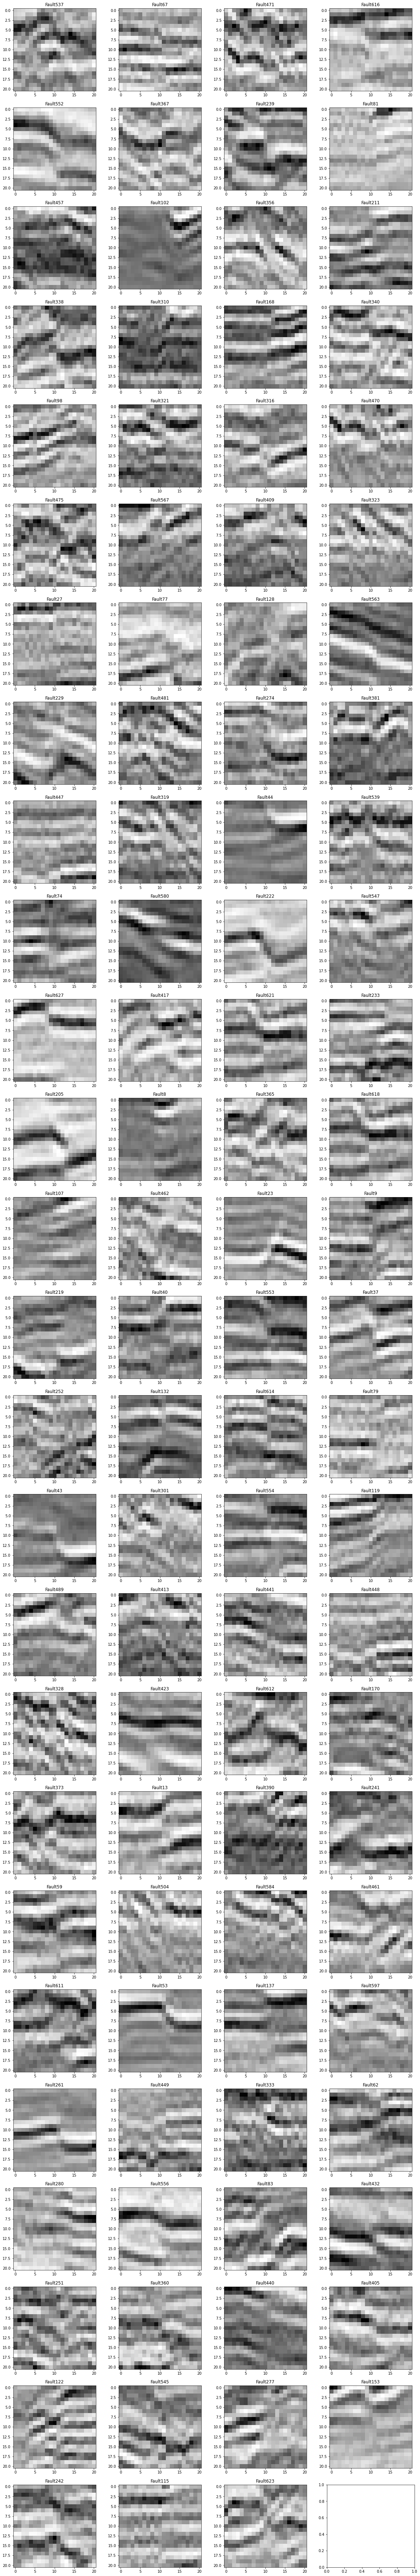

In [28]:
#FALHAS VERDADEIRO-POSITIVAS (CLASSIFICADA CORRETAMENTE COMO FALHA)

img_df = pd.DataFrame()
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test[i] == 1:
        img_df[X_test.copy().iloc[i].name] = X_test.copy().iloc[i]

cols = 4
rows = int(len(img_df.columns) / cols + 0.5)
fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

count = 0
for row in range(rows):
    for col in range(cols):
        try:
            img = np.array(img_df[img_df.columns[count]]).reshape(21,21)
            ax[row][col].imshow(img, cmap='Greys')
            ax[row][col].set_title(img_df.columns[count])

            count += 1
        except:
            pass

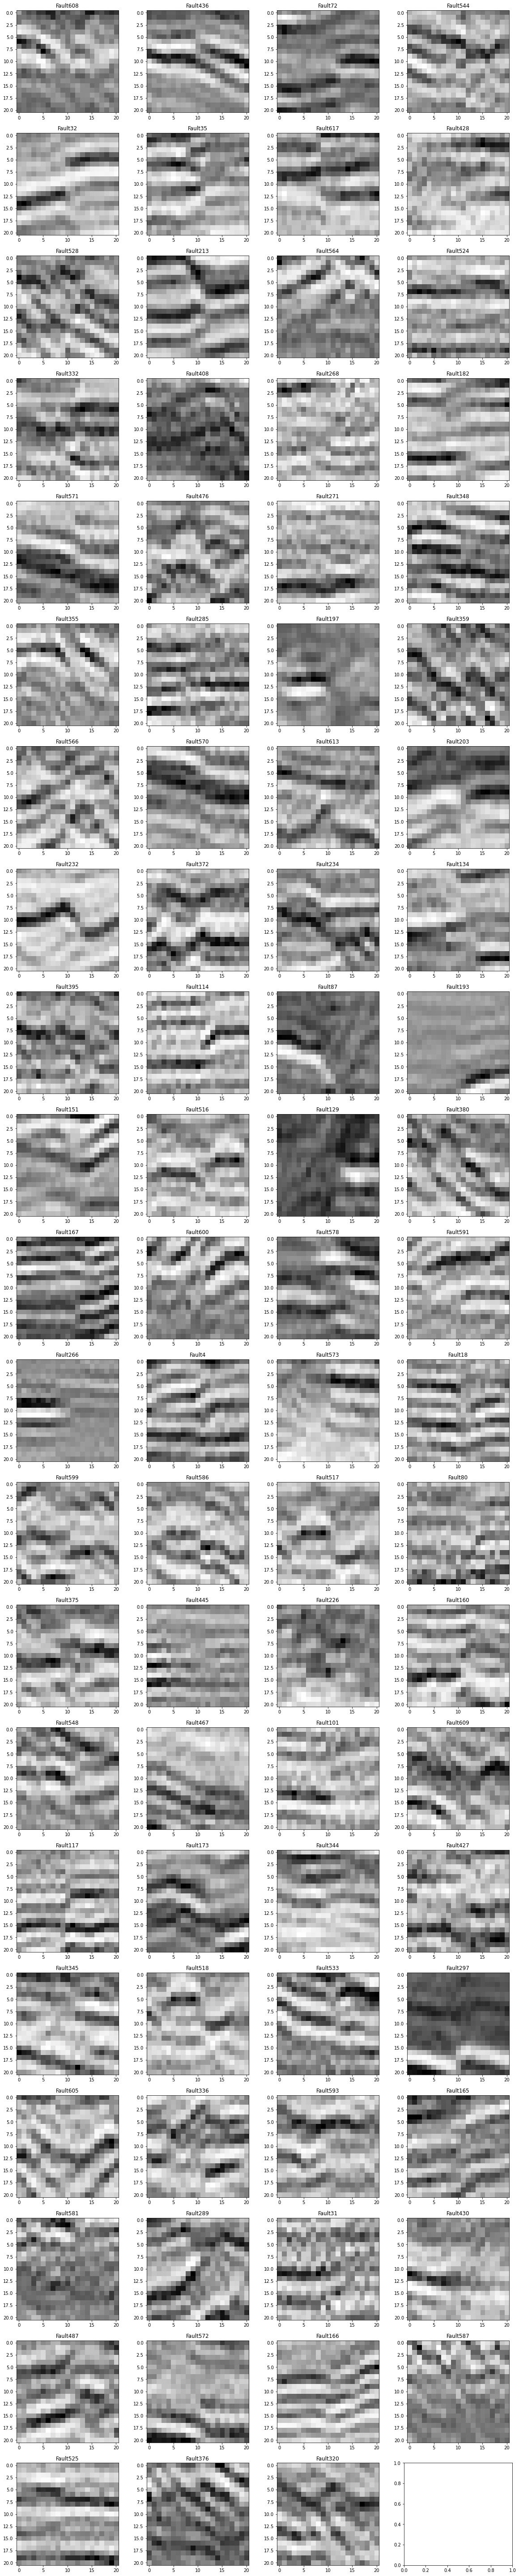

In [30]:
#FALSO NEGATIVO (CLASSIFICADA ERRONEAMENTE COMO "NÃO-FALHA")

img_df = pd.DataFrame()
for i in range(len(y_test)):
    if y_pred[i] == 0 and y_test[i] != 0:
        img_df[X_test.copy().iloc[i].name] = X_test.copy().iloc[i]

cols = 4
rows = int(len(img_df.columns) / cols + 0.5)
fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

count = 0
for row in range(rows):
    for col in range(cols):
        try:
            img = np.array(img_df[img_df.columns[count]]).reshape(21,21)
            ax[row][col].imshow(img, cmap='Greys')
            ax[row][col].set_title(img_df.columns[count])

            count += 1
        except:
            pass

In [32]:
derivatives = ['default', 'horizontal', 'vertical']
#derivatives = ['horizontal']

acc_train_list = []
acc_test_list = []
for derivative in derivatives:
    # CRIAÇÃO DOS DATASETS "X" E "y" E PARA TREINAMENTO E TESTE

    width = 21
    height = 21

    X_fault = obj_to_pixel_df(fault_obj, width, height, 'Fault', derivative)
    X_non_fault = obj_to_pixel_df(non_fault_obj, width, height, 'Non_Fault', derivative)

    dataset = pd.concat([X_fault, X_non_fault])

    dataset.rename(columns={i : f'Pixel{i}' for i in range(len(dataset.columns) - 1)}, inplace=True)

    dataset = dataset.sample(frac=1)

    X = dataset.iloc[:,:-1]
    y = dataset['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, train_size=0.7)

    # TREINAMENTO E TESTE

    model = DecisionTreeClassifier(criterion='entropy', max_depth=9)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)

    acc_train_list += [acc_train]
    acc_test_list += [acc]

for i in range(len(derivatives)):

    print(f'Derivative: {derivatives[i]} | Model Accuracy (Train): {round(acc_train_list[i] * 100, 2)}% | Model Accuracy (Test): {round(acc_test_list[i] * 100, 2)}%')

/tmp/ipykernel_3895/3245444971.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]
/tmp/ipykernel_3895/3245444971.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[count] = [pixel[0] for pixel in pixels.tolist()]
/tmp/ipykernel_3895/3245444971.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

Derivative: default | Model Accuracy (Train): 95.51% | Model Accuracy (Test): 65.67%
Derivative: horizontal | Model Accuracy (Train): 92.41% | Model Accuracy (Test): 68.66%
Derivative: vertical | Model Accuracy (Train): 80.66% | Model Accuracy (Test): 66.17%
